# Lab 10: Keyword Recognition

## Part 1: Making a Digit Recognizer

In this section we will design a simple spoken digit recognizer, based on Dynamic Time Warping (DTW). In order to make such a system we need to first collect some data, and then design a DTW routine that can compare new inputs with templates for each digit.

To start with make a set of data that will be used here. Make a dozen or so recordings of yourself speaking each of the ten digits (0 to 9). We will use one recording from each digit as the template, and the rest at testing data. In order to not spend too much time collecting the data, record all these utterances in a single (long) sound file. Use your voice activity detector to split that file into the individual spoken digits.

In order to design a digit recognizer we will take a spoken input of a digit and compare it to each digit’s template. By finding which template is the most similar we can classify the input as belonging to that template’s digit. In order to measure the distance between the two sequences we have to use DTW on an appropriate feature space.

Decide which feature to use to represent your speech signals. It can be any feature that we used in the past (e.g. some type of an STFT, MFCCs, etc). When comparing a template with a new input you need to perform the following steps:

1. Compute the distance matrix between all the features of each input. This will be a $M$ by $N$ matrix in which the $(i, j)$ element will represent the distance between the $i$-th frame of the template and the $j$-th frame of the input. We will use the cosine distance which is defined as:

$$D(a,b) = 1-\frac{\sum_i a_i b_i}{\sqrt{\sum_i a^2_i}\sqrt{\sum_i b^2_i}}$$

2. Once you obtain the distance matrix, you need to compute the cost matrix that encodes the cost of passing through a node given a previously optimal path. We will use the local constraint that to reach node $(i, j)$ you can either come from nodes $(i–1, j–1)$, $(i, j–1)$ or $(i–1, j)$.

3. Starting from the first element of the matrix (1,1), and for each element of the cost matrix you will need to perform the following steps. For node $(i, j)$ you need to examine the nodes from which you can reach it – these will be nodes $(i–1, j–1)$, $(i, j–1)$ or $(i–1, j)$ – and see which one has the lowest cost. Therefore, reaching that node from the optimal path will have the cost of the optimal preceding node plus the distance that corresponds to being at node $(i, j)$. Iterate until you calculate the cost of passing through every node. As you do that, for each node keep track of which of the three preceding nodes was the optimal one.

4. Now you can backtrack and find the optimal path. Start from the final point of the cost matrix and find the node from which you arrived there (it will be the same one that had the lowest cost above). Once you get to that node, repeat this process until you reach the beginning indexes of the two sequences. The path that you took in this process will be the optimal path that aligns the two sequences.

5. The distance between the two sequences will be the cost of being at the final node. Use this to perform the digit classification.

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np
import sounddevice as sd
from collections import defaultdict

In [2]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

In [3]:
def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # Zero padding to front and end of the input
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, input_sound)
    x = np.append(x, zero_padding)

    # Segment into shorter frames
    frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        # Apply analysis window
        frames.append(x[i:i+dft_size] * window)

    f = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        f.append(freq_vec)

    # Return a complex-valued spectrogram (frequencies x time)
    return np.hstack(f)

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    t = []
    for f in stft_output.T:
        t.append(np.fft.irfft(f, dft_size+zero_pad))
    t = np.array(t)

    x = np.zeros(dft_size+hop_size*(len(t)-1))
    for i in range(len(t)):
        x[i*hop_size:i*hop_size+dft_size] += t[i][:dft_size] * window
    
    # Return reconstructed waveform
    return x[dft_size:]

# Plot all the spectrograms
def plot_spectrogram(x, X, fs, title='', add_value=np.e):
    time_axis = np.linspace(0, len(x)/fs, X.shape[1])
    freq_axis = np.linspace(0, fs/2, X.shape[0])
    freq_abs = np.absolute(X)
    plt.pcolormesh(np.arange(freq_abs.shape[1]), freq_axis, np.log(freq_abs + add_value), cmap='Blues')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Freq (Hz)')
    plt.show()

In [4]:
# Voice Activity Detector (VAD)
def VAD(x, fs, threshold, min_num_clip_frames, max_num_under_threshold_frames):
    x_sq = np.square(x)

    b, a = signal.butter(2, 1, 'lowpass', fs=fs)
    e = signal.lfilter(b, a, x_sq)
    e = e.clip(min=0)
    
    clips = []
    clipping = False
    num_under_threshold_frames = 0

    for i in range(x.shape[0]):
        if clipping and e[i] < threshold:
            num_under_threshold_frames += 1
            if num_under_threshold_frames < max_num_under_threshold_frames and i - start_index > min_num_clip_frames:
                clips.append(x[start_index:i])
                clipping = False
            elif num_under_threshold_frames > max_num_under_threshold_frames:
                clipping = False
        elif not clipping and e[i] > threshold:
            start_index = i
            num_under_threshold_frames = 0
            clipping = True
            
    return clips

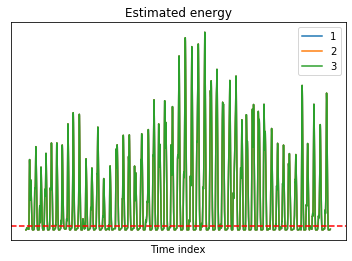

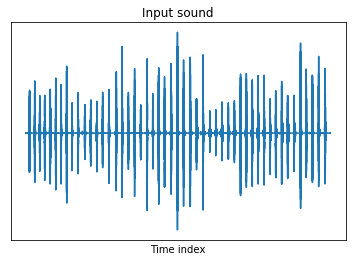

In [5]:
fs_digit, x_digit = wavfile.read('data/digits.wav')

# Voice Activity Detector (VAD)
digit_clips = VAD(x_digit, fs_digit, threshold=75, min_num_clip_frames=10000, max_num_under_threshold_frames=500)

x_sq = np.square(x_digit)
threshold = 75

# Lowpass filter among different cutoff frequency
plt.figure(1)
plt.title('Estimated energy')
plt.xlabel('Time index')
plt.yticks([])
plt.xticks([])
for cutoff_freq in range(1, 4, 1):
    b, a = signal.butter(2, 1, 'lowpass', fs=fs_digit)
    e = signal.lfilter(b, a, x_sq)
    e = e.clip(min=0)
    plt.plot(e, label=cutoff_freq)
plt.legend(loc='upper right')
# Threshold line
plt.axhline(y=threshold, color='r', linestyle='--')

plt.figure(2)
plt.title('Input sound')
plt.xlabel('Time index')
plt.yticks([])
plt.xticks([])
plt.plot(x_digit)
plt.show()

In [6]:
# Classify utternances to corresponding digit
records = defaultdict(list)
digit = 0
digit_cnt = 0
for i in range(len(digit_clips)):
    records[digit].append(digit_clips[i])
    digit_cnt += 1
    # Each digit has 5 utterances
    if digit_cnt == 5:
        digit += 1
        digit_cnt = 0

# Apply STFT
dft_size = 1024
hop_size = 1024
zero_pad = 0
window = signal.hann(dft_size, sym=False)

X = defaultdict(list)
for digit in records:
    for x in records[digit]:
        Xi = stft(x, dft_size, hop_size, zero_pad, window)
        # Only take the magnitude
        Xi = np.abs(Xi)
        X[digit].append(Xi)
        
# Select templates for Dynamic Time Warping (DTW)
templates = {}
template_index = 2
for digit in X:
    # Choose one utterance as template
    templates[digit] = X[digit][template_index]
    
# Create testing set by deleting templates
X_test = X.copy()
for digit in X_test:
    # Remove training utterance
    del X_test[digit][template_index]

In [7]:
# Digit classifier implemented by DTW
class DigitRecognizer():
    def __init__(self, templates, num_class):
        self.templates = templates
        self.num_class = num_class
        self.distance_matrix = {}
        self.cost_matrix = {}
        self.backtrack = {}
        
    def cosine_distance(self, a, b):
        return 1 - np.sum(np.dot(a, b)) / (np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)) + 1e-10)
        
    def calculate_distance_matrix(self, X_input):
        for digit in range(self.num_class):
            # D = (M, N), where M is the number of frame of the template and N is the number of frame of the input
            D = np.zeros((self.templates[digit].shape[1], X_input.shape[1]))
            for i in range(D.shape[0]):
                for j in range(D.shape[1]):
                    D[i][j] = self.cosine_distance(self.templates[digit][:, i], X_input[:, j])
            self.distance_matrix[digit] = D
                    
    def calculate_cost_matrix(self):
        for digit in range(self.num_class):
            D = self.distance_matrix[digit]
            
            C = np.zeros((D.shape[0], D.shape[1]))
            # B stores information for backtracking
            # 0: start
            # 1: from C[i][j-1]
            # 2: from C[i-1][j-1]
            # 3: from C[i-1][j]
            B = np.zeros((D.shape[0], D.shape[1]))
            
            for i in range(C.shape[0]):
                for j in range(C.shape[1]):
                    if i == 0 and j == 0:
                        C[i][j] = 0
                        B[i][j] = 0
                    elif i == 0:
                        C[i][j] = C[i][j-1] + D[i][j]
                        B[i][j] = 1
                    elif j == 0:
                        C[i][j] = C[i-1][j] + D[i][j]
                        B[i][j] = 3
                    else:
                        cand = [C[i][j-1], C[i-1][j-1], C[i-1][j]]
                        C[i][j] = np.min(cand) + D[i][j]
                        B[i][j] = np.argmin(cand) + 1
                        
            self.cost_matrix[digit] = C
            self.backtrack[digit] = B
            
    def backtracking(self, class_index):
        B = self.backtrack[class_index]
        path = []
        i, j = B.shape
        i -= 1
        j -= 1
        while True:
            path.append((i, j))
            prev = B[i][j]
            if prev == 1:
                j -= 1
            elif prev == 2:
                i -= 1
                j -= 1
            elif prev == 3:
                i -= 1
            elif prev == 0:
                break
        return path
    
    def predict(self, X_input):
        self.calculate_distance_matrix(X_input)
        self.calculate_cost_matrix()

        costs = []
        for digit in range(self.num_class):
            B = self.backtrack[digit]
            C = self.cost_matrix[digit]
            path = self.backtracking(digit)
            
            prev_node = path[0]
            for index in range(1, len(path)):
                i, j = path[index]
                # Find last node that does not lie on the border
                if i != C.shape[0] and j != C.shape[1]:
                    # Final node is first the node in the path that lies on the border
                    final_node = prev_node
                    break
                prev_node = (i, j)
            i, j = final_node
            costs.append(C[i][j])
        return np.argmin(costs)

In [8]:
# Create classifer instance with templates for DTW
DR = DigitRecognizer(templates=templates, num_class=10)

# Test classifer
true_cnt = 0
false_cnt = 0

for digit in X_test:
    for i in range(len(X_test[digit])):
        if digit == DR.predict(X_test[digit][i]):
            true_cnt += 1
        else:
            false_cnt += 1
            
print(f'Accuracy: {true_cnt / (true_cnt + false_cnt)}')

Accuracy: 0.875


## Part 2. Making a voice-driven dialer

Suppose you just started working for a phone company and the first thing they ask you is to make a hands-free interface for their phones so that people can dial in their friends by voice. During setup, the users speak the name of a contact and then associate it with a number to call. Make a system for which you use the full name of 4-5 of your friends, so that when you speak their name the system recognizes it (and thus could subsequently call their number)

In [9]:
fs_name, x_name = wavfile.read('data/names.wav')

# Voice Activity Detector (VAD)
name_clips = VAD(x_name, fs_name, threshold=30, min_num_clip_frames=20000, max_num_under_threshold_frames=5000)

# Create names and contacts information
names = ['Tai-Ying Chen', 'Steve Jobs', 'Jeff Bezos', 'Mark Zuckerberg', 'Bill Gates']
contacts = {
    'Tai-Ying Chen': '111-222-333',
    'Steve Jobs': '444-555-666',
    'Jeff Bezos': '777-888-999',
    'Mark Zuckerberg': '123-456-789',
    'Bill Gates': '987-654-321'
}
for i in range(len(name_clips)):
    sound(name_clips[i], fs_name, names[i])
    
# Apply STFT
dft_size = 1024
hop_size = 1024
zero_pad = 0
window = signal.hann(dft_size, sym=False)

X_names = {}
for i in range(len(name_clips)):
    Xi = stft(name_clips[i], dft_size, hop_size, zero_pad, window)
    # Only take the magnitude
    X_names[i] = np.abs(Xi)

Tai-Ying Chen


Steve Jobs


Jeff Bezos


Mark Zuckerberg


Bill Gates


In [10]:
# Name classifier inherit from digit classifer
class NameRecognizer(DigitRecognizer):
    def __init__(self, templates, num_class, names, contacts):
        self.names = names
        self.contacts = contacts
        super().__init__(templates, num_class)
        
    def predict(self, X_input):
        index = super().predict(X_input)
        return f'Calling to {names[index]}: {contacts[names[index]]}' 

In [11]:
NR = NameRecognizer(templates=X_names, num_class=5, names=names, contacts=contacts)

In [12]:
seconds = 2 # Duration of recording

myrecording = sd.rec(int(seconds * fs_name), samplerate=fs_name, channels=1)
sd.wait() # Wait until recording is finished

sound(myrecording.T, fs_name)

# Predict sound
X_test = stft(myrecording, dft_size, hop_size, zero_pad, window)
X_test = np.abs(X_test)
NR.predict(X_test)

'Calling to Tai-Ying Chen: 111-222-333'